In [ ]:
# Electricity Demand Forecasting in Delhi Using Machine Learning

This notebook implements the complete workflow used in the research paper:

> **Electricity Demand Forecasting in Delhi Using Machine Learning and Predictive Analytics**

It covers:

1. Data loading and preprocessing  
2. Feature engineering (lag features, moving average, time features)  
3. Train–test split (time-based)  
4. Baseline model (persistence)  
5. Linear Regression model  
6. Random Forest Regressor  
7. XGBoost Regressor (optional)  
8. Model evaluation using **MAE** and **RMSE**  
9. Visualization of predictions and feature importance  
10. Last 30 days demand trend



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# XGBoost is optional
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False
    print("XGBoost not installed. Install with: pip install xgboost if needed.")



The dataset  contain:

- `datetime` column (timestamp)
- `Power demand` column (target)
- Weather columns such as `temp`, `rhum`, `wspd`, `pres`, etc.


In [ ]:

csv_path = "powerdemand_5min_2021_to_2024_with weather.csv" 

df = pd.read_csv(csv_path)
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


In [4]:
# drop index column
df = df.drop(columns=['Unnamed: 0'])

# convert to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# set datetime index for resampling
df = df.set_index('datetime')

# resample to hourly mean to reduce dataset size
df_hourly = df.resample('H').mean()

print(df_hourly.shape)
print(df_hourly.head())

(34585, 13)
                     Power demand  temp  dwpt   rhum  wdir  wspd     pres  \
datetime                                                                    
2021-01-01 00:00:00   1975.541667   8.0  6.90   93.0   0.0   0.0  1017.00   
2021-01-01 01:00:00   1805.590000   8.0  6.90   93.0   0.0   0.0  1017.00   
2021-01-01 02:00:00   1665.914167   7.5  6.25   92.0   0.0   0.0  1018.05   
2021-01-01 03:00:00   1607.331667   7.0  6.30   95.5   0.0   0.0  1018.05   
2021-01-01 04:00:00   1676.528333   6.5  6.50  100.0   0.0   0.0  1017.00   

                       year  month  day  hour  minute  moving_avg_3  
datetime                                                             
2021-01-01 00:00:00  2021.0    1.0  1.0   0.0    42.5   1976.777500  
2021-01-01 01:00:00  2021.0    1.0  1.0   1.0    27.5   1822.649167  
2021-01-01 02:00:00  2021.0    1.0  1.0   2.0    27.5   1675.064722  
2021-01-01 03:00:00  2021.0    1.0  1.0   3.0    27.5   1608.205278  
2021-01-01 04:00:00  2021.0 

C:\Users\paulp\AppData\Local\Temp\ipykernel_17220\2262038785.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


In [5]:
for i in range(1, 25):  # last 24 hours
    df_hourly[f'lag_{i}'] = df_hourly['Power demand'].shift(i)

df_hourly = df_hourly.dropna()


In [6]:
# lag features for last 24 hours
for i in range(1, 25):
    df_hourly[f'lag_{i}'] = df_hourly['Power demand'].shift(i)

# drop rows with missing lag values
df_hourly = df_hourly.dropna()

# Feature columns
feature_cols = ['temp','dwpt','rhum','wdir','wspd','pres','moving_avg_3'] + \
               [f'lag_{i}' for i in range(1, 25)]

X = df_hourly[feature_cols]
y = df_hourly['Power demand']

print(X.shape, y.shape)


(25087, 31) (25087,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 80-20 split without shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# baseline model
baseline_pred = X_test['lag_1']
baseline_mae = mean_absolute_error(y_test, baseline_pred)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))

print("Baseline MAE:", baseline_mae)
print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)


Baseline MAE: 239.66338029507915
Linear Regression MAE: 7.23205846063261
Linear Regression RMSE: 20.204557045124076


In [10]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)




In [11]:
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest MAE: 15.651383174316829
Random Forest RMSE: 56.61899132682138


In [14]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 37.28782904885133
XGBoost RMSE: 101.3028225542478


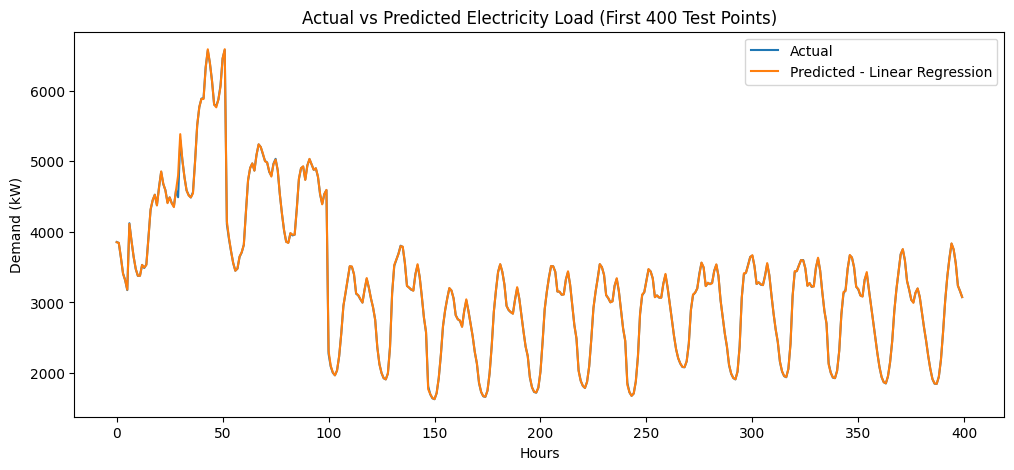

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label='Actual')
plt.plot(pred_lr[:400], label='Predicted - Linear Regression')
plt.title("Actual vs Predicted Electricity Load (First 400 Test Points)")
plt.xlabel("Hours")
plt.ylabel("Demand (kW)")
plt.legend()
plt.show()


In [18]:
pred_train = lr.predict(X_train)
train_mae = mean_absolute_error(y_train, pred_train)
print(train_mae, mae_lr)


5.545879540733281 7.23205846063261


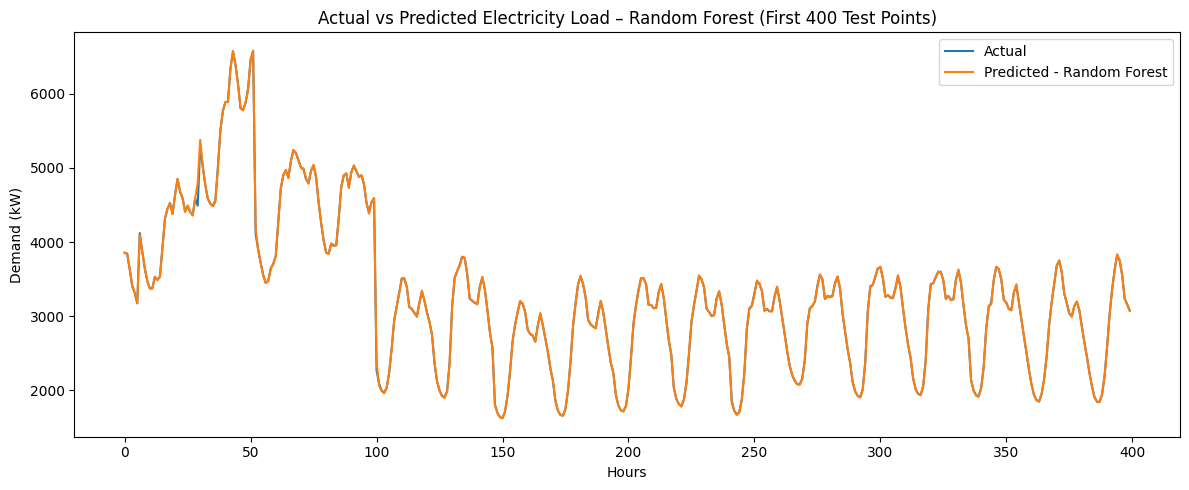

In [19]:
# import matplotlib.pyplot as plt

# Random Forest: Actual vs Predicted (first 400 test points)
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label='Actual')
plt.plot(pred_rf[:400], label='Predicted - Random Forest')
plt.title("Actual vs Predicted Electricity Load – Random Forest (First 400 Test Points)")
plt.xlabel("Hours")
plt.ylabel("Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


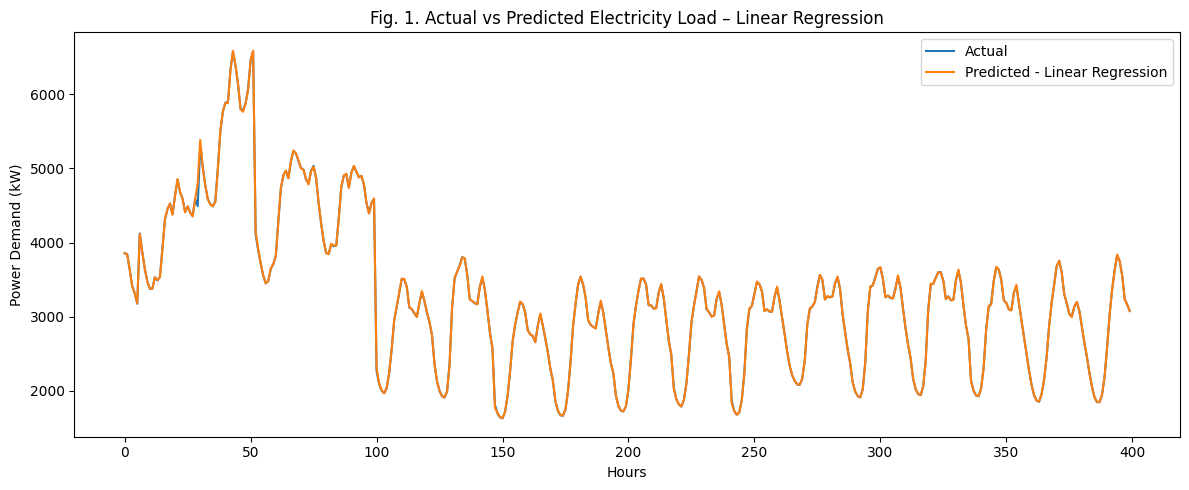

In [20]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label='Actual')
plt.plot(pred_lr[:400], label='Predicted - Linear Regression')
plt.title("Fig. 1. Actual vs Predicted Electricity Load – Linear Regression")
plt.xlabel("Hours")
plt.ylabel("Power Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


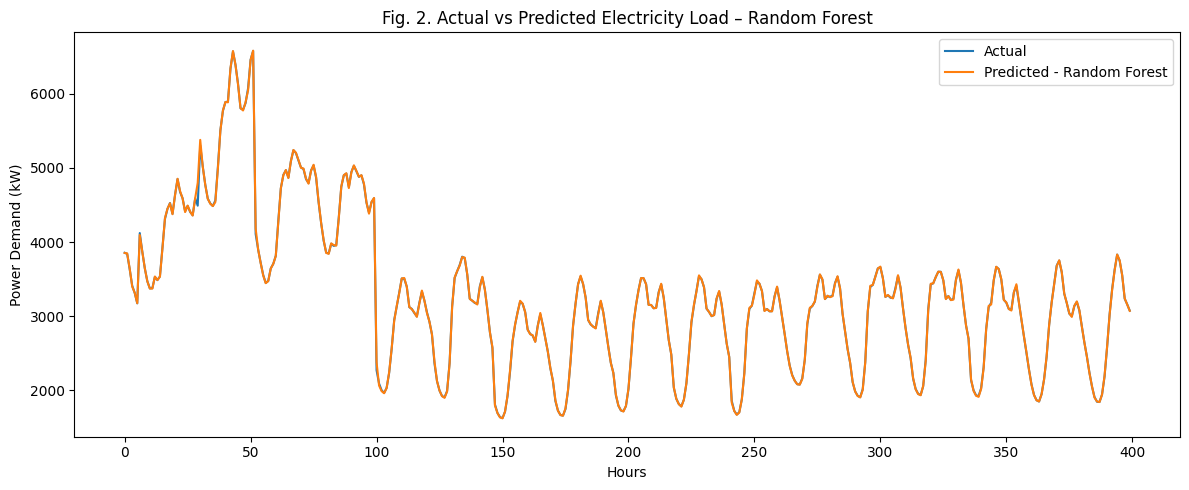

In [21]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label='Actual')
plt.plot(pred_rf[:400], label='Predicted - Random Forest')
plt.title("Fig. 2. Actual vs Predicted Electricity Load – Random Forest")
plt.xlabel("Hours")
plt.ylabel("Power Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


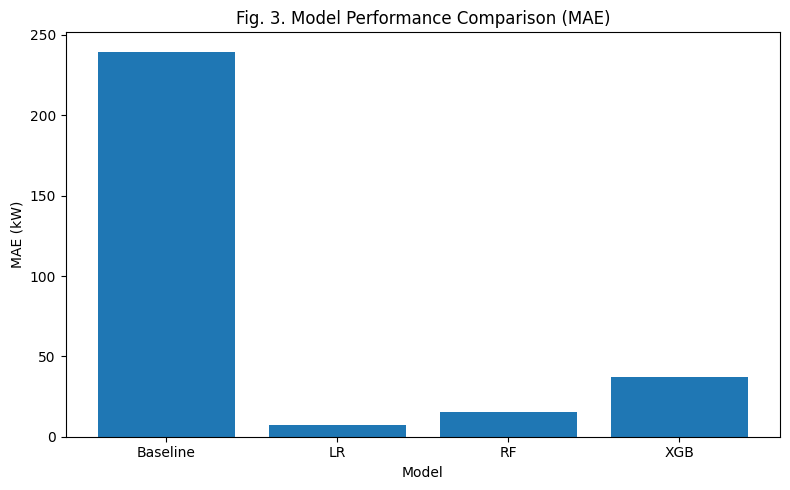

In [22]:
# import matplotlib.pyplot as plt

models = ["Baseline", "LR", "RF", "XGB"]
mae_values = [239.66, 7.23, 15.65, 37.28]

plt.figure(figsize=(8,5))
plt.bar(models, mae_values)
plt.title("Fig. 3. Model Performance Comparison (MAE)")
plt.xlabel("Model")
plt.ylabel("MAE (kW)")
plt.tight_layout()
plt.show()


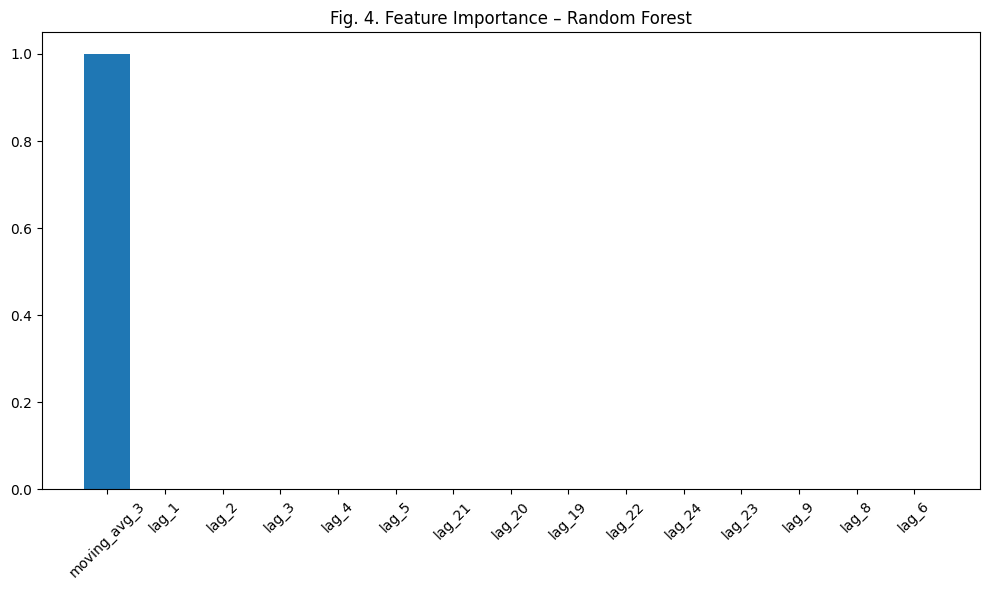

In [23]:
# import numpy as np
# import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Fig. 4. Feature Importance – Random Forest")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [X.columns[i] for i in indices][:15], rotation=45)
plt.tight_layout()
plt.show()


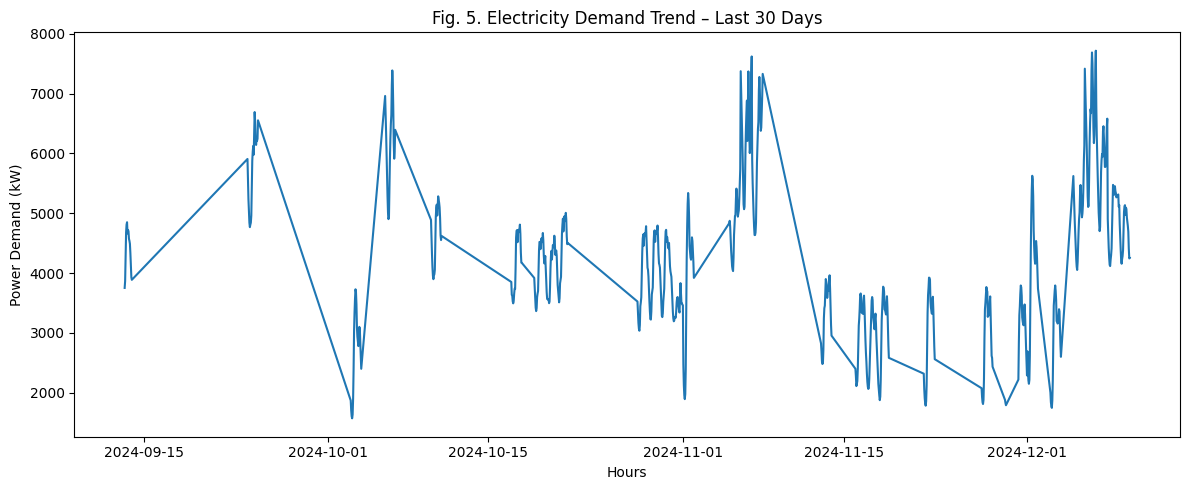

In [24]:
plt.figure(figsize=(12,5))
plt.plot(df_hourly['Power demand'].tail(720))
plt.title("Fig. 5. Electricity Demand Trend – Last 30 Days")
plt.xlabel("Hours")
plt.ylabel("Power Demand (kW)")
plt.tight_layout()
plt.show()
